# Colab init

In [ ]:
!pip install google-colab                   
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive/MLEX3")
%cd /content/drive/MyDrive/MLEX3/

In [ ]:
# !pip install adversarial-robustness-toolbox

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.attacks.evasion import UniversalPerturbation

# Loading and splitting dataset

In [5]:
def load_dataset(directory, size=(64,64)):
    X, y = [], []
    for folder in os.listdir(directory):
        try:
            label = int(folder[1:])  # folders 's1', 's2'...
        except:
            #... for README.md
            continue
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size) # resize to 64x64
            X.append(np.array(image))
            y.append(label)
    X = np.array(X) / 255.0  # normalize
    y = np.array(y) - 1  # labels start 0, not 1
    return X, y

In [6]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

# Build and train model

In [7]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40, activation='softmax')  # 40 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = build_model((64, 64, 1))

# instance early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50


/Users/markus/GitHub/LOCAL/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0241 - loss: 3.7316 - val_accuracy: 0.0750 - val_loss: 3.6861
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0850 - loss: 3.6699 - val_accuracy: 0.0625 - val_loss: 3.6714
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1358 - loss: 3.5675 - val_accuracy: 0.0250 - val_loss: 3.5532
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2069 - loss: 3.2477 - val_accuracy: 0.1375 - val_loss: 3.2794
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3523 - loss: 2.5625 - val_accuracy: 0.3250 - val_loss: 2.6504
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5134 - loss: 1.9378 - val_accuracy: 0.5125 - val_loss: 2.0359
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7011 - loss: 1.2096 - val_accuracy: 0.4625 - val_loss: 1.7125
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7974 - loss: 0.8674 - val_accuracy: 0.6875 - val_loss: 1.

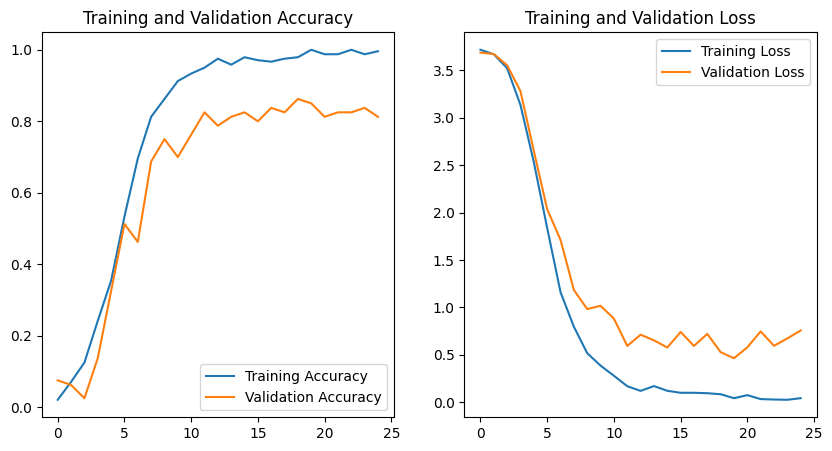

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fast gradient sign method

In [11]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
X_test_fgsm = attack_fgsm.generate(x=X_test)

In [14]:
def l0_norm(real, adversarial):
    return np.sum(real != adversarial)

def l2_norm(real, adversarial):
    return np.linalg.norm(real - adversarial)

def linf_norm(real, adversarial):
    return np.max(np.abs(real - adversarial))

def ssim_index(real, adversarial):
    real = real.astype(np.float64).squeeze(-1)
    adversarial = adversarial.astype(np.float64).squeeze(-1)
    return ssim(real, adversarial, data_range=1)

def psnr_index(real, adversarial):
    return psnr(real, adversarial, data_range=1)
# and combine this with different epsilons in fast gradient attack

In [15]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_fgsm):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 6.19487743184735
Average L∞ Distortion: 0.10000001533066523
Average SSIM: 0.5413210819615679
Average PSNR: 20.28294955520544


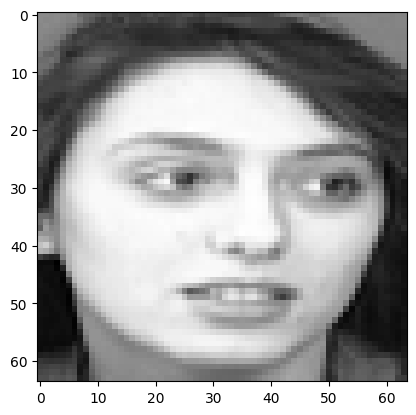

In [16]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

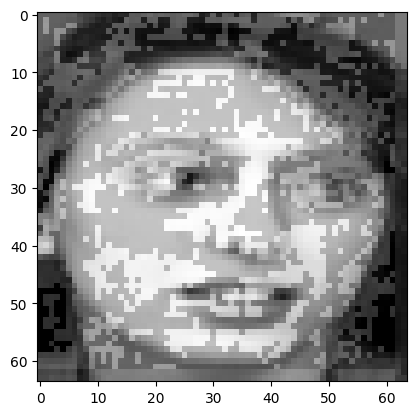

In [17]:
plt.imshow(X_test_fgsm[0].squeeze(), cmap='gray')

In [18]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_fgsm = model.evaluate(x=X_test_fgsm, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs FGSM test set loss: {score_fgsm[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs FGSM test set accuracy: {score_fgsm[1]:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9836 - loss: 0.1439 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0102 - loss: 12.0722     
Clean test set loss: 0.18 vs FGSM test set loss: 12.10
Clean test set accuracy: 0.98 vs FGSM test set accuracy: 0.01


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9594 - loss: 0.1587 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9453 - loss: 0.1851 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9289 - loss: 0.2414 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8727 - loss: 0.3142 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8344 - loss: 0.4047 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5727 - loss: 1.3844 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1250 - loss: 4.5060 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0281 - loss: 8.2578 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0102 - loss: 12.0722     
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━

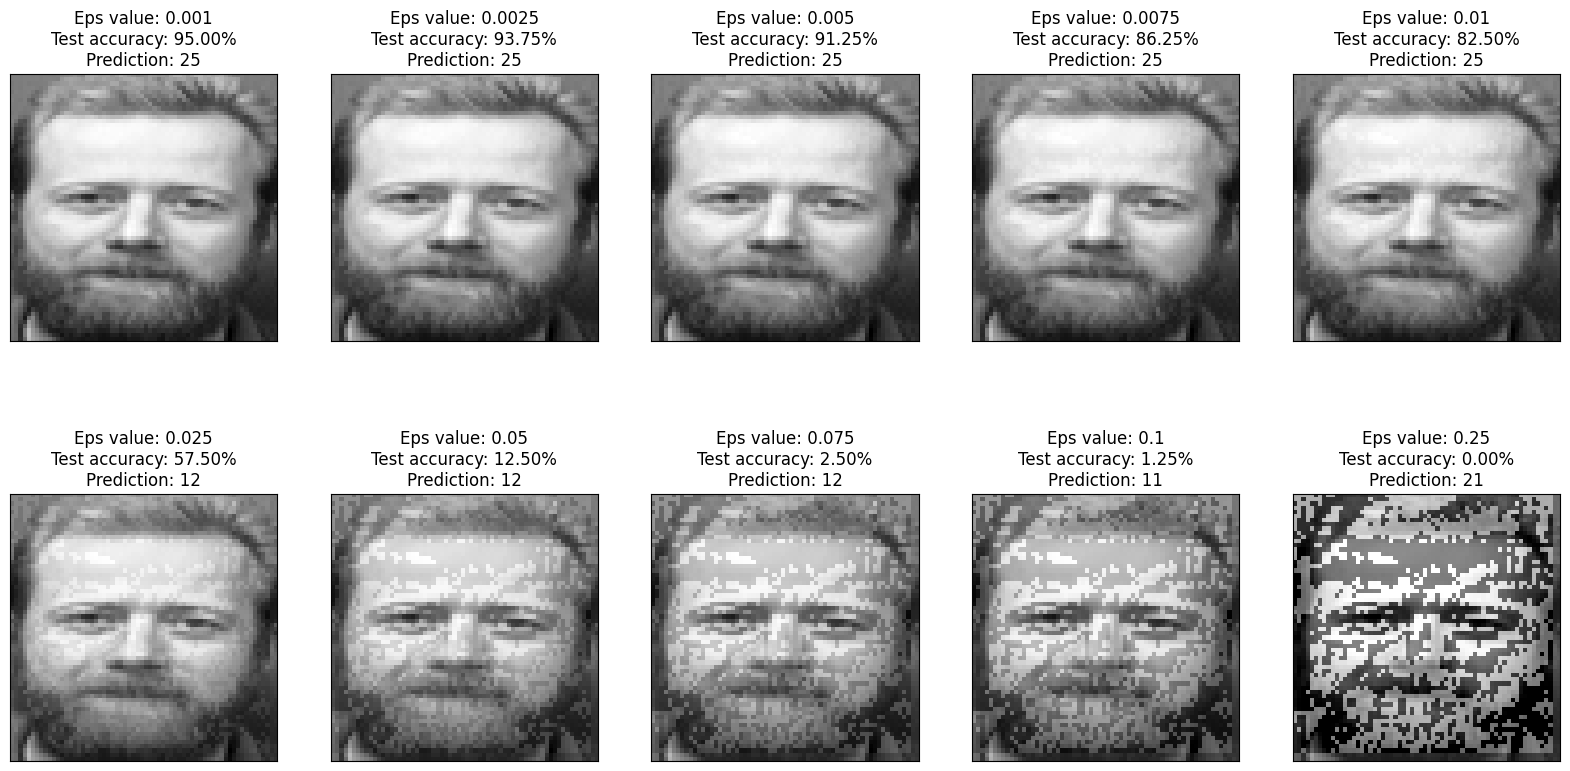

In [19]:
# plot setting
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

eps_to_try = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
counter = 0

for i in range(nrows):
    for j in range(ncols):

        attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps_to_try[counter])
        X_test_fgsm = attack_fgsm.generate(x=X_test)

        axes[i, j].imshow(X=X_test_fgsm[5].squeeze(), cmap='gray')
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        test_score = classifier._model.evaluate(x=X_test_fgsm, y=y_test)[1]
        prediction = np.argmax(model.predict(x=np.expand_dims(a=X_test_fgsm[5], axis=0)))

        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        counter += 1

plt.show()

# Deepfool

In [20]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_df = DeepFool(classifier=classifier)
X_test_df = attack_df.generate(x=X_test)

DeepFool:   0%|          | 0/80 [00:00<?, ?it/s]

In [21]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_df):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 15.802446407342064
Average L∞ Distortion: 0.6886355425687689
Average SSIM: 0.379107269650918
Average PSNR: 19.777832392221416


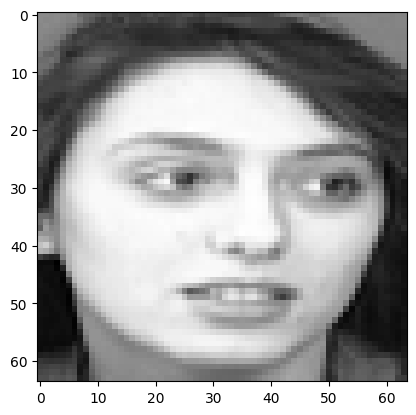

In [22]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

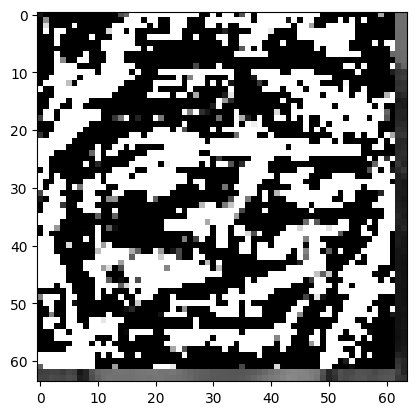

In [23]:
plt.imshow(X_test_df[0].squeeze(), cmap='gray')

In [24]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_df = model.evaluate(x=X_test_df, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs DF test set loss: {score_df[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs DF test set accuracy: {score_df[1]:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9836 - loss: 0.1439 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0102 - loss: 32.6907     
Clean test set loss: 0.18 vs DF test set loss: 32.34
Clean test set accuracy: 0.98 vs DF test set accuracy: 0.01


# Universal perturbation

In [25]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_up = UniversalPerturbation(classifier=classifier, attacker='fgsm', eps=0.1)
X_test_up = attack_up.generate(x=X_test)

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_up):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 6.194588456158152
Average L∞ Distortion: 0.10000000000000006
Average SSIM: 0.5538710219651282
Average PSNR: 20.283358548388996


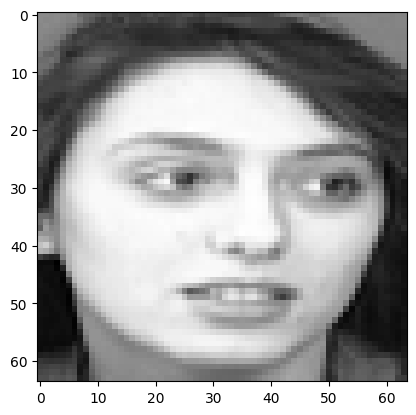

In [27]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

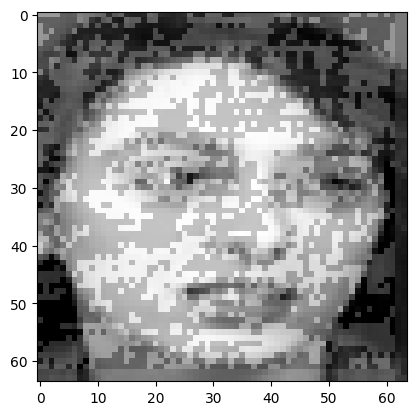

In [28]:
plt.imshow(X_test_up[0].squeeze(), cmap='gray')

In [29]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_up = model.evaluate(x=X_test_up, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs UP test set loss: {score_up[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs UP test set accuracy: {score_up[1]:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9836 - loss: 0.1439 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4055 - loss: 2.8837 
Clean test set loss: 0.18 vs UP test set loss: 3.01
Clean test set accuracy: 0.98 vs UP test set accuracy: 0.41
